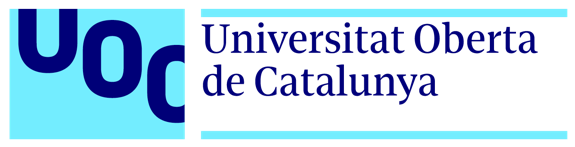

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Librerías de manipulación de datos
import pandas as pd
import numpy as np
import joblib

# Librerías de visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D

# Librerías de procesaso de datos
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.inspection import permutation_importance
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Input
import tensorflow
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


1. Carga de los datos

2. Funciones generales

3. Generación red neuronal artificial

4. Evaluación red neuronal artificial

5. Características importantes

6. Guardado del mejor modelo

# 1. Carga de los datos

In [2]:
data = pd.read_csv("../data/case_control_episode.csv")
data.head()

,BreastCancer,Age,Family_History,episode_1,episode_2,episode_3,episode_4,episode_5,episode_6,episode_7,...,bbd_none,bbd_unknown,bbd_no_proliferative,bbd_proliferative,mf_none,mf_mass,mf_calcification,mf_asymetric_density,mf_distorsion,mf_multiple_patron
0,0.0,0.368421,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.105263,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.052632,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.210526,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 2. Funciones generales

In [3]:
def grid_search(model, params, X_train, y_train):
    """
    Función genérica para aplicar la búsqueda de rejilla
    al modelo determinado mediante validación cruzada
    Args:
        model: modelo a aplicar a la búsqueda
        params: parámetros a comprobar
        X_train: datos de entrenamiento de los factores
        y_train: datos de entrenamiento de la clase
        cv: validación cruzada a aplicar
    Returns:
        Devuelve el mejor estimador entrenado
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    model_search = GridSearchCV(estimator=model, param_grid=params,
                                scoring='accuracy', n_jobs=-1, cv=cv, refit=True)

    # Se entrena el mejor estimados
    model_search.fit(X_train, y_train)
    
    print("Los mejores parámetros son:", model_search.best_params_)

    return model_search

In [4]:
def evaluate_model(model, X_test, y_test):
    """
    Función genérica para evaluar los modelos
    Args:
        model: modelo a aplicar a la búsqueda
        X_test: datos de test de los factores
        y_test: datos de test de la clase
    """            
    y_pred_test = model.predict(X_test)
    
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    print("-"*50)
    print("Accuracy en test: ", accuracy_score(y_test, y_pred_test))
    print("-"*50)
    print("AUC: ", roc_auc_score(y_test, y_pred_test))
    print("-"*50)
    print("Clasificación en test: ")
    print(classification_report(y_test, y_pred_test))
    print("-"*50)
    print("Matriz de confusión en test: ")
    print(test_confusion_matrix)
    print("-"*50)
    sns.set(font_scale=1.4)
    ann_cm = sns.heatmap(test_confusion_matrix, annot=True, annot_kws={"size": 12}, fmt="g")
    plt.xlabel("Valores predichos");
    plt.ylabel("Valores reales"); 
    plt.show()
    figure = ann_cm.get_figure()
    figure.savefig("../plots/ann_model_confusion_matrix.png", bbox_inches="tight")

In [5]:
def create_model(neurons1=1, neurons2=1, neurons3=1, neurons4=1, lr=0.001):
    """
    Función genérica para generar la red neuronal
    Args:
        neurons1: número neuronas por capa
        neurons2: número neuronas por capa
        neurons3: número neuronas por capa
        neurons4: número neuronas por capa
        neurons4: número neuronas por capa
    """
    # Definición del modelo
    model = Sequential()
    model.add(Dense(neurons1, input_dim = 22, activation = "relu"))
    model.add(Dense(neurons2, activation = "relu"))
    model.add(Dense(neurons3, activation = "relu"))
    model.add(Dense(neurons4, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    # Compilación del modelo
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=lr), metrics = ["accuracy"])

    return model

# 3. Generación red neuronal artificial

## 3.1 Partición de los datos

In [6]:
# Partición de los datos en entrenamiento y test con una proporción 85/15

X = data.iloc[:, data.columns != "BreastCancer"].values.astype(float)
y = data.iloc[:, data.columns == "BreastCancer"].values.astype(float)

# Repartición balanceada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

## 3.2 Definición parámetros

In [7]:
ann_grid = {
    "neurons1": [100, 150, 175],
    "neurons2": [50, 75, 100],
    "neurons3": [30, 50],
    "neurons4": [10, 20, 30],
    "batch_size": [256, 512],
    "epochs": [30, 50],
    "lr": [0.01, 0.1]
}

## 3.3. Definición de la red neuronal

In [8]:
model = KerasClassifier(build_fn=create_model, verbose=0)

## 3.4 Búsqueda de rejilla

In [9]:
%%time

result = grid_search(model, ann_grid, X_train, y_train)
    
# Mejor estimador
best_model = result.best_estimator_

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using Tensor

Los mejores parámetros son: {'batch_size': 512, 'epochs': 50, 'lr': 0.01, 'neurons1': 150, 'neurons2': 75, 'neurons3': 50, 'neurons4': 20}
CPU times: user 28.3 s, sys: 13.3 s, total: 41.6 s
Wall time: 2h 22min 56s


# 4. Evaluación red neuronal artificial

Accuracy media sobre train, validación cruzada: 60.33 +/- 0.64 %
--------------------------------------------------
Accuracy en test:  0.6264462809917355
--------------------------------------------------
AUC:  0.624436683874886
--------------------------------------------------
Clasificación en test: 
              precision    recall  f1-score   support

         0.0       0.61      0.73      0.67       925
         1.0       0.65      0.52      0.58       890

    accuracy                           0.63      1815
   macro avg       0.63      0.62      0.62      1815
weighted avg       0.63      0.63      0.62      1815

--------------------------------------------------
Matriz de confusión en test: 
[[674 251]
 [427 463]]
--------------------------------------------------


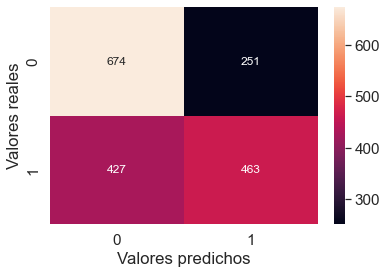

In [10]:
# Validación cruzada para determinar la confiabilidad del modelo
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cvscores_random = cross_val_score(best_model, X_train, y_train, cv = cv)

print("Accuracy media sobre train, validación cruzada: "
      "{:.2f} +/- {:.2f} %".format(np.mean(cvscores_random)*100, np.std(cvscores_random)*100))

# Muestra de resultados sobre el mejor modelo
evaluate_model(best_model, X_test, y_test)

# 5. Características importantes

Age                     0.076325
Family_History          0.018221
episode_1               0.015673
episode_2               0.003209
episode_3               0.007759
episode_4               0.011823
episode_5               0.014468
episode_6               0.012543
episode_7               0.003850
episode_8               0.001147
episode_9               0.000175
episode_10              0.000292
bbd_none                0.016140
bbd_unknown             0.011881
bbd_no_proliferative    0.005192
bbd_proliferative       0.001906
mf_none                 0.028352
mf_mass                 0.015887
mf_calcification        0.010540
mf_asymetric_density    0.003034
mf_distorsion           0.002859
mf_multiple_patron      0.006145
dtype: float64


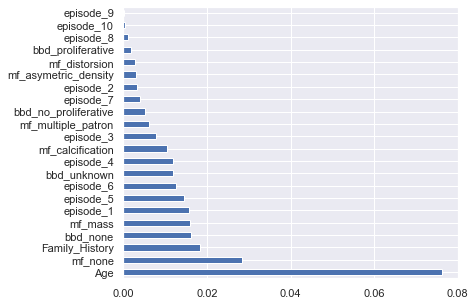

In [11]:
# Importancia de la característica de permutación
perm_importance = permutation_importance(best_model, X_train, y_train)

# Características importantes
importance_features = pd.Series(perm_importance.importances_mean,
                       index=data.iloc[:, 1: 23].columns)

# Muestra de las características
print(importance_features)
plt.figure(figsize=(6, 5))
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
importance_features.nlargest(22).plot.barh()
plt.savefig("../plots/ann_model_feature_importance.png", bbox_inches="tight")

In [12]:
# Se agrupan los resultados por variables originales

episode = importance_features.episode_1 + importance_features.episode_2 + importance_features.episode_3
+ importance_features.episode_4 + importance_features.episode_5 + importance_features.episode_6
+ importance_features.episode_7 + importance_features.episode_8 + importance_features.episode_9
+ importance_features.episode_10

bbd = importance_features.bbd_none + importance_features.bbd_unknown + importance_features.bbd_no_proliferative
+ importance_features.bbd_proliferative

mf = importance_features.mf_none + importance_features.mf_mass + importance_features.mf_calcification
+ importance_features.mf_asymetric_density + importance_features.mf_distorsion
+ importance_features.mf_multiple_patron

features_importance = []
features_importance.extend([])
features_importance.extend((importance_features.Age, episode, importance_features.Family_History, bbd, mf))
features_importance = np.array(features_importance)

Age                      0.076325
Episode                  0.026641
Family_History           0.018221
BBD_History              0.033213
Mammographic_Features    0.054779
dtype: float64


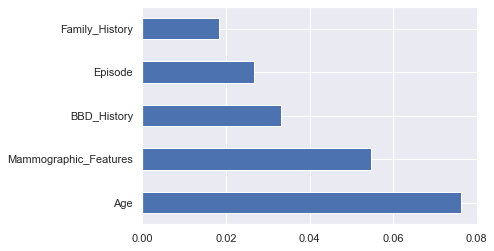

In [13]:
general_feature_importance = pd.Series(features_importance,
                       index=["Age", "Episode", "Family_History", "BBD_History", "Mammographic_Features"])

# Muestra de las características generales
print(general_feature_importance)
plt.figure(figsize=(6,4))
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
general_feature_importance.nlargest(5).plot.barh()
plt.savefig("../plots/ann_model_feature_importance_general.png", bbox_inches="tight")

In [15]:
data_x = data.iloc[:, data.columns != "BreastCancer"]

for i in perm_importance.importances_mean.argsort()[::-1]:
    if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0:
        print(f"{data_x.columns[i]:<8} "
            f"{perm_importance.importances_mean[i]:.4f}"
            f" +/- {perm_importance.importances_std[i]:.4f}")

Age      0.0763 +/- 0.0044
mf_none  0.0284 +/- 0.0017
Family_History 0.0182 +/- 0.0011
bbd_none 0.0161 +/- 0.0016
mf_mass  0.0159 +/- 0.0022
episode_1 0.0157 +/- 0.0032
episode_5 0.0145 +/- 0.0012
episode_6 0.0125 +/- 0.0009
bbd_unknown 0.0119 +/- 0.0013
episode_4 0.0118 +/- 0.0010
mf_calcification 0.0105 +/- 0.0014
episode_3 0.0078 +/- 0.0012
mf_multiple_patron 0.0061 +/- 0.0006
bbd_no_proliferative 0.0052 +/- 0.0007
episode_7 0.0039 +/- 0.0004
episode_2 0.0032 +/- 0.0013
mf_asymetric_density 0.0030 +/- 0.0005
mf_distorsion 0.0029 +/- 0.0004
bbd_proliferative 0.0019 +/- 0.0004
episode_8 0.0011 +/- 0.0002
episode_10 0.0003 +/- 0.0001


# 6. Guardado del mejor modelo

In [14]:
model_json = result.best_estimator_.model.to_json()
with open("../saved_models/ann_model.json", "w") as json_file:
    json_file.write(model_json)
result.best_estimator_.model.save_weights("../saved_models/ann_model.h5")

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
